In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

2025-09-17 15:04:57.894 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\Fusion3DNet


Project root added to path: d:\workspace\projects\freelance\Fusion3DNet


In [60]:
BREPNET_NPZ_DIR = INTERIM_DATA_DIR / "features" / "brepnet"
DINO_NPZ_DIR = INTERIM_DATA_DIR / "features" / "dino"
STEP_DIR = PROCESSED_DATA_DIR / "dataset_129" / "stp"
STATS_BREPNET = INTERIM_DATA_DIR / 'features' / "brepnet_feature_standard.json"

In [3]:
import numpy as np
from pathlib import Path
files = list(Path(BREPNET_NPZ_DIR).glob("*.npz"))

feats = np.load(files[0], allow_pickle=True)

for k, v in feats.items():
    print(k, v.shape)


face_features (9, 7)
face_point_grids (9, 7, 10, 10)
edge_features (16, 10)
coedge_point_grids (31, 12, 10)
coedge_features (31, 1)
coedge_lcs (31, 4, 4)
coedge_scale_factors (31,)
coedge_reverse_flags (31,)
next (31,)
mate (31,)
face (31,)
edge (31,)


In [4]:
from src.data_loader.custom_dataset_v2 import CustomDataset

dataset = CustomDataset(
    step_data=STEP_DIR,
    brepnet_data=BREPNET_NPZ_DIR,
    dino_data=DINO_NPZ_DIR,
    compute_stats=True,
    apply_standardization=True,
)

print(f"Dataset length: {len(dataset)}")


Loading dataset: 100%|██████████| 129/129 [00:03<00:00, 33.96it/s]

Dataset length: 129


In [5]:
from typing import Tuple
import torch
from torch import nn

class FaceEncoder(nn.Module):
    """
    Кодирует UV‑сигнал грани: [B, 7, U, V] -> [B, D]
    """
    def __init__(self, in_ch: int = 7, out_dim: int = 128) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(64, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)  # [B, out_dim]

class CoedgeEncoder(nn.Module):
    """
    Кодирует 1D‑сигнал коэджа: [B, 12, U] -> [B, D]
    """
    def __init__(self, in_ch: int = 12, out_dim: int = 128) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 64, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 64, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)  # [B, out_dim]

In [6]:
from __future__ import annotations
from typing import Optional
import torch
from torch import Tensor
from torch_geometric.data import HeteroData


class CoedgeLCSNormalize:
    """
    Нормализация coedge.grid в локальной системе коэджа с учётом масштаба и reverse-флага.
    Ожидаемые поля:
      - data['coedge'].grid:  [C, 12, U]  (xyz | t | nL | nR)
      - data['coedge'].lcs:   [C,  4, 4]  (гомогенная матрица)
      - data['coedge'].scale: [C]
      - data['coedge'].reverse: [C] bool
    Возвращает обновлённый data с grid в LCS.
    """
    def __init__(self, apply_reverse: bool = True, renorm_vectors: bool = False) -> None:
        self.apply_reverse = apply_reverse
        self.renorm_vectors = renorm_vectors

    @torch.no_grad()
    def __call__(self, data: HeteroData) -> HeteroData:
        grid: Tensor = data["coedge"].grid           # [C,12,U]
        lcs: Tensor = data["coedge"].lcs            # [C,4,4]
        scale: Tensor = data["coedge"].scale        # [C]
        rev: Tensor = data["coedge"].reverse        # [C] bool

        assert grid.dim() == 3 and grid.size(1) == 12, f"grid shape {tuple(grid.shape)}"  # [C,12,U]
        C, _, U = grid.shape
        assert lcs.shape == (C, 4, 4), f"lcs shape {tuple(lcs.shape)}"
        assert scale.shape == (C,), f"scale shape {tuple(scale.shape)}"
        assert rev.shape == (C,), f"reverse shape {tuple(rev.shape)}"

        # Разбор каналов: работаем в [C,3,U]
        xyz = grid[:, 0:3, :]    # [C,3,U]
        tng = grid[:, 3:6, :]    # [C,3,U]
        nL  = grid[:, 6:9, :]    # [C,3,U]
        nR  = grid[:, 9:12, :]   # [C,3,U]

        # Из LCS берём R и t, и сразу строим R^{-1}, t^{-1}
        R = lcs[:, :3, :3]                     # [C,3,3]
        t = lcs[:, :3,  3]                     # [C,3]
        R_inv = R.transpose(1, 2).contiguous() # [C,3,3]
        t_inv = -(R_inv @ t.unsqueeze(-1)).squeeze(-1)  # [C,3]

        # Перенос в начало LCS: xyz' = R^{-1} (xyz - t)
        xyz_local = xyz - t.unsqueeze(-1)                      # [C,3,U]
        xyz_local = torch.einsum('cij,cju->ciu', R_inv, xyz_local)  # [C,3,U]

        # Поворот направлений (нормали/касательные не масштабируем по длине)
        tng_local = torch.einsum('cij,cju->ciu', R_inv, tng)   # [C,3,U]
        nL_local  = torch.einsum('cij,cju->ciu', R_inv, nL)    # [C,3,U]
        nR_local  = torch.einsum('cij,cju->ciu', R_inv, nR)    # [C,3,U]

        # Масштаб (делим координаты, векторы оставляем единичными)
        s = scale.view(C, 1, 1).clamp_min(1e-8)                # [C,1,1]
        xyz_local = xyz_local / s

        # Опциональная нормализация направлений
        if self.renorm_vectors:
            def _renorm(v: Tensor) -> Tensor:
                n = torch.linalg.norm(v, dim=1, keepdim=True).clamp_min(1e-8)
                return v / n
            tng_local = _renorm(tng_local)
            nL_local  = _renorm(nL_local)
            nR_local  = _renorm(nR_local)

        # Обработка реверса: разворот вдоль U, смена знака касательной, перестановка nL/nR
        if self.apply_reverse and rev.any():
            idx = torch.nonzero(rev, as_tuple=False).flatten()
            xyz_local[idx] = torch.flip(xyz_local[idx], dims=[-1])
            tng_local[idx] = -torch.flip(tng_local[idx], dims=[-1])
            nL_flip = torch.flip(nR_local[idx], dims=[-1])
            nR_flip = torch.flip(nL_local[idx], dims=[-1])
            nL_local[idx], nR_local[idx] = nL_flip, nR_flip

        data["coedge"].grid = torch.cat([xyz_local, tng_local, nL_local, nR_local], dim=1).contiguous()  # [C,12,U]
        return data

In [7]:
import torch
from torch import nn
from torch_geometric.nn import HeteroConv, SAGEConv

class BRepHeteroGNN(nn.Module):
    """
    Гетерограф: узлы 'face'/'edge'/'coedge'; ребра:
      ('coedge','next','coedge'), ('coedge','mate','coedge'),
      ('coedge','to_face','face'), ('coedge','to_edge','edge').
    """
    def __init__(self, hidden: int = 128, out_dim: int = 256) -> None:
        super().__init__()
        self.conv1 = HeteroConv({
            ('coedge', 'next', 'coedge'): SAGEConv((-1, -1), hidden),
            ('coedge', 'mate', 'coedge'): SAGEConv((-1, -1), hidden),
            ('coedge', 'to_face', 'face'): SAGEConv((-1, -1), hidden),
            ('coedge', 'to_edge', 'edge'): SAGEConv((-1, -1), hidden),
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('coedge', 'next', 'coedge'): SAGEConv((-1, -1), hidden),
            ('coedge', 'mate', 'coedge'): SAGEConv((-1, -1), hidden),
            ('coedge', 'to_face', 'face'): SAGEConv((-1, -1), hidden),
            ('coedge', 'to_edge', 'edge'): SAGEConv((-1, -1), hidden),
        }, aggr='sum')
        self.readout = nn.ModuleDict({
            'coedge': nn.Linear(hidden, out_dim),
            'face': nn.Linear(hidden, out_dim),
            'edge': nn.Linear(hidden, out_dim),
        })

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: torch.relu(v) for k, v in x_dict.items()}
        z_dict = {k: self.readout[k](v) for k, v in x_dict.items()}
        return z_dict  # per-type embeddings

In [8]:
from __future__ import annotations
from typing import Tuple
import torch
from torch import Tensor
from torch_geometric.data import HeteroData


def dropout_attrs(data: HeteroData, p: float = 0.1) -> HeteroData:
    """
    Простейшая атрибутивная аугментация: зануляем случайные элементы в grid/uv.
    Безопасно для топологии (edge_index не трогаем).
    """
    out = data.clone()
    if "uv" in out["face"]:
        uv = out["face"].uv
        mask = torch.rand_like(uv) < p
        out["face"].uv = uv.masked_fill(mask, 0.0)
    grid = out["coedge"].grid
    mask = torch.rand_like(grid) < p
    out["coedge"].grid = grid.masked_fill(mask, 0.0)
    return out


def two_views(data: HeteroData, p: float = 0.1) -> Tuple[HeteroData, HeteroData]:
    return dropout_attrs(data, p), dropout_attrs(data, p)

In [ ]:
# losses/topo_pointer.py
from __future__ import annotations
from typing import Tuple
import torch
from torch import Tensor, nn
import torch.nn.functional as F


class BilinearScorer(nn.Module):
    """
    Билинейный скорер s(i,j)=zi^T W zj для коэджей, учит различать целевые next/mate среди узлов того же графа.
    """
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.W = nn.Parameter(torch.eye(dim))

    def forward(self, z_i: Tensor, z_j: Tensor) -> Tensor:
        # z_i: [N, D], z_j: [M, D] -> scores: [N, M]
        return z_i @ self.W @ z_j.t()


@torch.no_grad()
def build_target_from_edge_index(edge_index: Tensor, num_nodes: int) -> Tensor:
    """
    Превращает edge_index [2, C] (дуга из i в j для каждого i) в target: target[i]=j для всех источников i.
    Предполагается по одному выходу из каждого i (как у next/mate). 
    """
    src, dst = edge_index[0], edge_index[1]
    target = torch.full((num_nodes,), -1, dtype=torch.long, device=edge_index.device)
    target[src] = dst
    return target

def graph_pointer_ce(
    z: Tensor,
    batch_vec: Tensor,
    target_global: Tensor,
    scorer: BilinearScorer,
    temperature: float = 0.2,
) -> Tuple[Tensor, Tensor]:
    """
    Cross-entropy по указателю внутри каждого графа: для узла i выбираем класс как ближайший узел в своём графе.
    Возвращает (loss, acc_top1).
    """
    z = nn.functional.normalize(z, dim=-1)
    loss_sum: Tensor = z.new_zeros(())
    correct = 0
    total = 0
    for g in batch_vec.unique():
        idx = (batch_vec == g).nonzero(as_tuple=False).flatten()       # узлы текущего графа
        if idx.numel() < 2:
            continue
        zg = z.index_select(0, idx)                                    # [Ng, D]
        tg = target_global.index_select(0, idx)                         # [Ng]
        # игнорируем узлы без целевого (на полюсах сфер и т.п.)
        mask = tg.ge(0)
        if mask.sum() == 0:
            continue
        zg_q = zg[mask]                                                 # источники
        # логиты по всем j внутри графа
        logits = scorer(zg_q, zg) / temperature                         # [Nq, Ng]
        # таргеты в локальных индексах графа
        tgt_idx = tg[mask]
        # сопоставим глобальные индексы целевых с локальными
        map_local = {int(idx[k]): k for k in range(idx.numel())}
        tgt_local = torch.tensor([map_local[int(j)] for j in tgt_idx.tolist()],
                                 device=z.device, dtype=torch.long)
        loss_sum = loss_sum + nn.functional.cross_entropy(logits, tgt_local)

        pred = logits.argmax(dim=1)
        correct += (pred == tgt_local).sum().item()
        total += tgt_local.numel()
    avg_loss = loss_sum / max(total, 1)
    acc = z.new_tensor(correct / max(total, 1))
    return avg_loss, acc

In [10]:
from __future__ import annotations
from typing import Dict, Tuple
import torch
from torch import Tensor


@torch.no_grad()
def alignment(z1: Tensor, z2: Tensor) -> Tensor:
    """
    Средняя квадратичная дистанция между эмбеддингами позитивных пар (чем меньше, тем лучше).
    Ожидает z1,z2 нормализованными по L2. [ICML'20 alignment] 
    """
    z1n = torch.nn.functional.normalize(z1, dim=-1)
    z2n = torch.nn.functional.normalize(z2, dim=-1)
    return ((z1n - z2n) ** 2).sum(dim=-1).mean()


@torch.no_grad()
def uniformity(z: Tensor, t: float = 2.0, max_points: int = 2048) -> Tensor:
    """
    Оценка равномерности на сфере: E[exp(-t * ||zi - zj||^2)], меньше — равномернее.
    Используем случайную подвыборку для квадратичной части. [ICML'20 uniformity]
    """
    z = torch.nn.functional.normalize(z, dim=-1)
    n = z.size(0)
    if n > max_points:
        idx = torch.randperm(n, device=z.device)[:max_points]
        z = z[idx]
        n = z.size(0)
    # попарные расстояния без диагонали
    sim = z @ z.t()
    d2 = (2 - 2 * sim).clamp_min(0)  # ||zi - zj||^2 = 2 - 2 cos
    d2 = d2 + torch.eye(n, device=z.device) * 1e6
    val = torch.exp(-t * d2)
    return (val.sum() - n * torch.exp(torch.tensor(-t * 1e6, device=z.device))) / (n * (n - 1))


@torch.no_grad()
def info_nce_top1_accuracy(z1: Tensor, z2: Tensor, tau: float = 0.2) -> Tensor:
    """
    Accuracy: для каждого i, позитивный j=i должен быть argmax среди всех z2. [SimCLR kNN/linear eval практика]
    """
    q = torch.nn.functional.normalize(z1, dim=-1)
    k = torch.nn.functional.normalize(z2, dim=-1)
    logits = (q @ k.t()) / tau
    pred = logits.argmax(dim=1)
    labels = torch.arange(q.size(0), device=q.device)
    return (pred == labels).float().mean()


@torch.no_grad()
def build_target_from_edge_index(edge_index: Tensor, num_nodes: int) -> Tensor:
    """
    Превращает edge_index вида [2, C] (уникальная дуга на коэдж) в вектор таргетов длины C:
    target[i] = j, куда ведёт ребро из i. [используем для mate/next]
    """
    assert edge_index.dim() == 2 and edge_index.size(0) == 2
    src, dst = edge_index[0], edge_index[1]
    target = torch.full((num_nodes,), -1, dtype=torch.long, device=edge_index.device)
    target[src] = dst
    return target


@torch.no_grad()
def top1_retrieval_accuracy_within_graphs(
    z: Tensor,
    edge_index: Tensor,
    batch_vec: Tensor,
) -> Tensor:
    """
    Для каждого узла находим ближайшего соседа по косинусу в пределах своего графа (исключая себя)
    и сравниваем с таргетом из edge_index (mate или next). Возвращаем среднюю точность. 
    """
    z = torch.nn.functional.normalize(z, dim=-1)
    num_nodes = z.size(0)
    target = build_target_from_edge_index(edge_index, num_nodes)
    assert target.ge(0).all(), "edge_index должен покрывать все источники"
    acc_sum, cnt = 0.0, 0
    for g in batch_vec.unique():
        mask = batch_vec == g
        idx = mask.nonzero(as_tuple=False).flatten()
        if idx.numel() < 2:
            continue
        zg = z.index_select(0, idx)
        sim = zg @ zg.t()
        sim.fill_diagonal_(-1.0)  # исключаем себя
        nn_local = sim.argmax(dim=1)                      # локальные индексы
        nn_global = idx[nn_local]                         # обратно в глобальные
        tgt_global = target.index_select(0, idx)          # таргеты для этой группы
        acc_sum += (nn_global == tgt_global).float().sum().item()
        cnt += idx.numel()
    return torch.tensor(acc_sum / max(cnt, 1), device=z.device)

In [11]:
from __future__ import annotations
import torch
from torch_geometric.data import HeteroData

def num_graphs_in_batch(batch: HeteroData) -> int:
    """
    Возвращает число графов в HeteroDataBatch через ptr любого типа узла.
    По умолчанию используем 'coedge', иначе пробуем другие типы.
    """
    for node_type in ["coedge", "face", "edge"]:
        if node_type in batch and hasattr(batch[node_type], "ptr") and batch[node_type].ptr is not None:
            return int(batch[node_type].ptr.numel() - 1)
    return 1

In [112]:
# ssl/improved_augment.py
from __future__ import annotations
import torch
from torch import Tensor
from torch_geometric.data import HeteroData
import numpy as np
from typing import Tuple


def mask_faces_randomly(data: HeteroData, p: float = 0.15) -> HeteroData:
    """
    Маскирует случайные грани целиком - более структурная аугментация
    """
    data = data.clone()
    num_faces = data["face"].x.size(0) if "x" in data["face"] else data["face"].uv.size(0)
    
    # Выбираем какие грани маскировать
    mask_faces = torch.rand(num_faces) < p
    
    if mask_faces.any():
        # Маскируем UV решётки граней
        if "uv" in data["face"]:
            data["face"].uv[mask_faces] = 0.0
        if "x" in data["face"]:
            data["face"].x[mask_faces] = 0.0
            
        # Маскируем связанные с этими гранями коэджи
        if ("coedge", "to_face", "face") in data.edge_index_dict:
            c2f_edges = data[("coedge", "to_face", "face")].edge_index
            coedges_to_mask = c2f_edges[0][mask_faces[c2f_edges[1]]]
            if coedges_to_mask.numel() > 0:
                data["coedge"].grid[coedges_to_mask] *= 0.5  # частично маскируем
    
    return data


def dropout_topology(data: HeteroData, p: float = 0.1) -> HeteroData:
    """
    Дропаут связей next/mate - учит устойчивость к топологическим изменениям
    """
    data = data.clone()
    
    # Дропаут next связей
    if ("coedge", "next", "coedge") in data.edge_index_dict:
        next_edges = data[("coedge", "next", "coedge")].edge_index
        keep_mask = torch.rand(next_edges.size(1)) > p
        data[("coedge", "next", "coedge")].edge_index = next_edges[:, keep_mask]
    
    # Дропаут mate связей  
    if ("coedge", "mate", "coedge") in data.edge_index_dict:
        mate_edges = data[("coedge", "mate", "coedge")].edge_index
        keep_mask = torch.rand(mate_edges.size(1)) > p
        data[("coedge", "mate", "coedge")].edge_index = mate_edges[:, keep_mask]
    
    return data


def spatial_masking(data: HeteroData, p: float = 0.2) -> HeteroData:
    """
    Пространственное маскирование - скрываем случайные области модели
    """
    data = data.clone()
    
    if "grid" in data["coedge"]:
        # Маскируем участки по пространственным координатам
        grid = data["coedge"].grid  # [C, 12, U]
        xyz = grid[:, 0:3, :]       # координаты
        
        # Находим центр и радиус для сферической маски
        center = xyz.mean(dim=[0, 2], keepdim=True)  # [1, 3, 1]
        distances = torch.norm(xyz - center, dim=1)   # [C, U]
        
        # Маскируем случайный радиальный слой
        radius_threshold = torch.quantile(distances.flatten(), torch.rand(1) * 0.5 + 0.25)
        spatial_mask = distances < radius_threshold # [C, U]
        
        # Применяем маску с вероятностью p
        if torch.rand(1) < p:
            # --- ИСПРАВЛЕНИЕ ---
            # Расширяем 2D маску [C, U] до 3D [C, 1, U]
            expanded_mask = spatial_mask.unsqueeze(1) # -> [C, 1, U]
            # Явно транслируем маску до полного размера тензора grid [C, 12, U]
            full_mask = expanded_mask.expand_as(data["coedge"].grid)
            
            # Теперь формы полностью совпадают, и индексация работает
            data["coedge"].grid[full_mask] *= 0.3
    
    return data


def advanced_attribute_masking(data: HeteroData, p_uv: float = 0.15, p_grid: float = 0.15) -> HeteroData:
    """
    Более умное маскирование атрибутов по каналам
    """
    data = data.clone()
    
    # Маскирование UV по патчам
    if "uv" in data["face"]:
        uv = data["face"].uv  # [F, 7, 10, 10]
        F, C, H, W = uv.shape
        
        # Патчевое маскирование вместо случайного
        patch_size = 3
        for f in range(F):
            if torch.rand(1) < p_uv:
                # Случайный патч
                h_start = torch.randint(0, H - patch_size + 1, (1,)).item()
                w_start = torch.randint(0, W - patch_size + 1, (1,)).item()
                uv[f, :, h_start:h_start+patch_size, w_start:w_start+patch_size] = 0.0
    
    # Селективное маскирование каналов коэджей
    if "grid" in data["coedge"]:
        grid = data["coedge"].grid  # [C, 12, U]
        
        # Маскируем разные каналы с разной вероятностью
        if torch.rand(1) < p_grid:
            # Касательные (каналы 3-6)
            tangent_mask = torch.rand_like(grid[:, 3:6, :]) < 0.3
            grid[:, 3:6, :] = grid[:, 3:6, :] * (~tangent_mask).float()
        
        if torch.rand(1) < p_grid * 0.5:
            # Нормали (каналы 6-12) - маскируем реже, они важнее
            normal_mask = torch.rand_like(grid[:, 6:12, :]) < 0.2  
            grid[:, 6:12, :] = grid[:, 6:12, :] * (~normal_mask).float()
    
    return data


def improved_two_views(data: HeteroData, 
                      p_face_mask: float = 0.15,
                      p_topo_drop: float = 0.08, 
                      p_spatial: float = 0.2,
                      p_attr: float = 0.12) -> Tuple[HeteroData, HeteroData]:
    """
    Комбинированная стратегия аугментаций для двух view
    """
    # Первый view - больше структурных изменений
    v1 = mask_faces_randomly(data, p=p_face_mask)
    v1 = dropout_topology(v1, p=p_topo_drop)
    v1 = advanced_attribute_masking(v1, p_uv=p_attr, p_grid=p_attr)
    
    # Второй view - больше пространственных и атрибутивных
    v2 = spatial_masking(data, p=p_spatial)
    v2 = advanced_attribute_masking(v2, p_uv=p_attr * 1.2, p_grid=p_attr * 1.2)
    if torch.rand(1) < 0.5:  # иногда добавляем топологический дропаут
        v2 = dropout_topology(v2, p=p_topo_drop * 0.5)
    
    return v1, v2

In [106]:
# models/mae_decoder.py
from __future__ import annotations
import torch
from torch import nn, Tensor
from torch_geometric.data import HeteroData
from typing import Dict, Tuple


class BRepMAEDecoder(nn.Module):
    """
    Декодер для восстановления замаскированных частей B-Rep
    """
    def __init__(self, hidden_dim: int = 128, face_channels: int = 7, coedge_channels: int = 12):
        super().__init__()
        
        # Декодеры для разных типов узлов
        self.face_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, face_channels * 10 * 10),  # UV решётка
        )
        
        self.coedge_decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2), 
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, coedge_channels * 10),  # grid решётка
        )
        
        self.face_channels = face_channels
        self.coedge_channels = coedge_channels
    
    def forward(self, z_dict: Dict[str, Tensor], target_shapes: Dict[str, torch.Size]) -> Dict[str, Tensor]:
        reconstructed = {}
        
        # Восстанавливаем UV грани
        if "face" in z_dict:
            face_flat = self.face_decoder(z_dict["face"])  # [F, 7*10*10]
            F = face_flat.size(0)
            reconstructed["face_uv"] = face_flat.view(F, self.face_channels, 10, 10)
        
        # Восстанавливаем коэдж решётки  
        if "coedge" in z_dict:
            coedge_flat = self.coedge_decoder(z_dict["coedge"])  # [C, 12*10]
            C = coedge_flat.size(0)
            reconstructed["coedge_grid"] = coedge_flat.view(C, self.coedge_channels, 10)
            
        return reconstructed


def compute_reconstruction_loss(pred: Dict[str, Tensor], 
                               target: Dict[str, Tensor],
                               mask: Dict[str, Tensor]) -> Tensor:
    """
    Считает reconstruction loss только для замаскированных областей
    """
    total_loss = 0.0
    count = 0
    
    # Loss для UV граней
    if "face_uv" in pred and "face_uv" in target and "face_mask" in mask:
        face_mask_tensor = mask["face_mask"]
        # Проверяем, есть ли что-то в маске
        if face_mask_tensor.any():
            face_loss = nn.functional.mse_loss(
                torch.masked_select(pred["face_uv"], face_mask_tensor), 
                torch.masked_select(target["face_uv"], face_mask_tensor)
            )
            total_loss += face_loss
            count += 1
    
    # Loss для коэдж решёток
    if "coedge_grid" in pred and "coedge_grid" in target and "coedge_mask" in mask:
        coedge_mask_tensor = mask["coedge_mask"]
        # Проверяем, есть ли что-то в маске
        if coedge_mask_tensor.any():
            pred_masked = torch.masked_select(pred["coedge_grid"], coedge_mask_tensor)
            target_masked = torch.masked_select(target["coedge_grid"], coedge_mask_tensor)

            coedge_loss = nn.functional.mse_loss(
                pred_masked,
                target_masked
            )
            total_loss += coedge_loss  
            count += 1
    
    return total_loss / max(count, 1) # type: ignore

In [108]:
from __future__ import annotations
from typing import Dict, Tuple
import torch
from torch import nn, Tensor
import pytorch_lightning as pl
from torch_geometric.data import HeteroData

class SSLBRepModule(pl.LightningModule):
    """
    SSL‑модуль без «магических» чисел: tau/aug_p/lambda_topo берутся из атрибутов.
    """
    def __init__(
        self,
        proj_dim: int = 128,
        lr: float = 1e-3,
        hidden: int = 128,
        tau: float = 0.1,
        lambda_topo_mate: float = 1.5,
        lambda_topo_next: float = 1.5,
        aug_p: float = 0.15,
        topo_tau: float | None = 0.07, 
        weight_decay: float = 1e-4,

        use_mae_decoder: bool = True,
        lambda_recon: float = 0.5,
    ) -> None:
        super().__init__()
        # модели
        self.face_enc = FaceEncoder(in_ch=7, out_dim=hidden)
        self.coedge_enc = CoedgeEncoder(in_ch=12, out_dim=hidden)
        self.edge_lin = nn.Linear(10, hidden)
        self.gnn = BRepHeteroGNN(hidden=hidden, out_dim=2 * hidden)
        self.projector = nn.Sequential(
            nn.Linear(2 * hidden, 2 * hidden),
            nn.ReLU(inplace=True),
            nn.Linear(2 * hidden, proj_dim),
        )
        self.norm = CoedgeLCSNormalize(apply_reverse=True, renorm_vectors=False)
        self.scorer_next = BilinearScorer(dim=2 * hidden)
        self.scorer_mate = BilinearScorer(dim=2 * hidden)

        # гиперпараметры
        self.lr = lr
        self.weight_decay = weight_decay
        self.tau = float(tau)
        self.topo_tau = float(topo_tau) if topo_tau is not None else float(tau)
        self.lambda_topo_mate = lambda_topo_mate
        self.lambda_topo_next = lambda_topo_next
        self.aug_p = float(aug_p)

        self.use_mae_decoder = use_mae_decoder
        self.lambda_recon = lambda_recon
        
        if use_mae_decoder:
            self.mae_decoder = BRepMAEDecoder(hidden_dim=2*hidden)


        self.save_hyperparameters() 

    # ===== общие подфункции =====
    def _embed(self, batch: HeteroData) -> Dict[str, Tensor]:
        batch = self.norm(batch)
        x_dict = {
            "face": self.face_enc(batch["face"].uv),
            "coedge": self.coedge_enc(batch["coedge"].grid),
            "edge": self.edge_lin(batch["edge"].x.float()),
        }
        z_dict = self.gnn(x_dict, {
            ("coedge","next","coedge"): batch[("coedge","next","coedge")].edge_index,
            ("coedge","mate","coedge"): batch[("coedge","mate","coedge")].edge_index,
            ("coedge","to_face","face"): batch[("coedge","to_face","face")].edge_index,
            ("coedge","to_edge","edge"): batch[("coedge","to_edge","edge")].edge_index,
        })
        return z_dict

    def _contrastive_loss(self, z1: Tensor, z2: Tensor) -> Tensor:
        # единая реализация NT‑Xent с настраиваемой температурой
        p1 = nn.functional.normalize(self.projector(z1), dim=-1)
        p2 = nn.functional.normalize(self.projector(z2), dim=-1)
        logits = (p1 @ p2.t()) / self.tau
        labels = torch.arange(p1.size(0), device=p1.device)
        return nn.functional.cross_entropy(logits, labels)

    # ===== обучение/валидация =====
    def training_step(self, batch: HeteroData, _: int) -> Tensor:
        # аугментации берут вероятность
        
        # v1, v2 = two_views(batch, p=self.aug_p)
        v1, v2 = improved_two_views(batch, 
                                   p_face_mask=0.15,
                                   p_topo_drop=0.08, 
                                   p_spatial=0.2,
                                   p_attr=self.aug_p)
        
        z1d = self._embed(v1)
        z2d = self._embed(v2)

        # контраст
        loss_con = self._contrastive_loss(z1d["coedge"], z2d["coedge"])
        p1 = torch.nn.functional.normalize(self.projector(z1d["coedge"]), dim=-1)
        p2 = torch.nn.functional.normalize(self.projector(z2d["coedge"]), dim=-1)
        logits = (p1 @ p2.t()) / self.tau
        labels = torch.arange(p1.size(0), device=p1.device)
        info_acc = (logits.argmax(dim=1) == labels).float().mean()

        # топологические предтексты с настраиваемой температурой
        co_batch = batch["coedge"].batch
        next_ei = batch[("coedge","next","coedge")].edge_index
        mate_ei = batch[("coedge","mate","coedge")].edge_index
        tgt_next = build_target_from_edge_index(next_ei, z1d["coedge"].size(0))
        tgt_mate = build_target_from_edge_index(mate_ei, z1d["coedge"].size(0))

        loss_next, acc_next = graph_pointer_ce(
            z1d["coedge"], co_batch, tgt_next, self.scorer_next, temperature=self.topo_tau
        )
        loss_mate, acc_mate = graph_pointer_ce(
            z1d["coedge"], co_batch, tgt_mate, self.scorer_mate, temperature=self.topo_tau
        )
        loss_recon = 0.0
        if self.use_mae_decoder:
            # Восстанавливаем оригинальные данные из аугментированного представления v1
            reconstructed = self.mae_decoder(z1d, {"face": batch["face"].uv.shape, "coedge": batch["coedge"].grid.shape})
            
            # --- НАЧАЛО ИЗМЕНЕНИЙ ---
            # Убедимся, что тензоры имеют одинаковую форму перед isclose
            v1_grid = v1["coedge"].grid
            orig_grid = batch["coedge"].grid
            min_u = min(v1_grid.shape[-1], orig_grid.shape[-1])
            
            # Создаем маски, используя срезы одинакового размера
            face_mask = ~torch.isclose(v1["face"].uv, batch["face"].uv)
            coedge_mask = ~torch.isclose(v1_grid[:, :, :min_u], orig_grid[:, :, :min_u])

            recon_targets = {
                "face_uv": batch["face"].uv, 
                "coedge_grid": orig_grid[:, :, :min_u] # Используем тот же срез
            }
            recon_preds = {
                "face_uv": reconstructed["face_uv"],
                "coedge_grid": reconstructed["coedge_grid"][:, :, :min_u] # и здесь
            }
            recon_masks = {"face_mask": face_mask, "coedge_mask": coedge_mask}
            
            loss_recon = compute_reconstruction_loss(recon_preds, recon_targets, recon_masks)

        loss = (
        
            loss_con 
                + self.lambda_topo_next * loss_next 
                + self.lambda_topo_mate * loss_mate
                + self.lambda_recon * loss_recon
        )

        bsz = num_graphs_in_batch(batch)
        self.log_dict({
            "train_loss": loss,
            "train_loss_con": loss_con,
            "train_loss_next": loss_next,
            "train_loss_mate": loss_mate,
            "train_infoNCE_acc": info_acc,
            "train_topo_next_top1": acc_next,
            "train_topo_mate_top1": acc_mate,
        }, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=bsz) 
        return loss

    @torch.no_grad()
    def validation_step(self, batch: HeteroData, _: int) -> None:
        # Аугментации: такие же, как в train (или p=0.0 для «чистой» оценки)
        # v1, v2 = two_views(batch, p=self.aug_p)
        v1, v2 = improved_two_views(batch, 
                                   p_face_mask=0.15,
                                   p_topo_drop=0.08, 
                                   p_spatial=0.2,
                                   p_attr=self.aug_p)

        # Эмбеддинги
        z1d = self._embed(v1)
        z2d = self._embed(v2)

        # Контрастная часть (val/loss_con) и accuracy
        val_loss_con = self._contrastive_loss(z1d["coedge"], z2d["coedge"])
        p1 = torch.nn.functional.normalize(self.projector(z1d["coedge"]), dim=-1)
        p2 = torch.nn.functional.normalize(self.projector(z2d["coedge"]), dim=-1)
        logits = (p1 @ p2.t()) / self.tau
        labels = torch.arange(p1.size(0), device=p1.device)
        val_info_acc = (logits.argmax(dim=1) == labels).float().mean()

        # Топологические предтексты (val/loss_next, val/loss_mate) и topo@1
        co_batch = batch["coedge"].batch
        next_ei = batch[("coedge","next","coedge")].edge_index
        mate_ei = batch[("coedge","mate","coedge")].edge_index
        tgt_next = build_target_from_edge_index(next_ei, z1d["coedge"].size(0))
        tgt_mate = build_target_from_edge_index(mate_ei, z1d["coedge"].size(0))

        val_loss_next, val_topo_next = graph_pointer_ce(
            z1d["coedge"], co_batch, tgt_next, self.scorer_next, temperature=self.topo_tau
        )
        val_loss_mate, val_topo_mate = graph_pointer_ce(
            z1d["coedge"], co_batch, tgt_mate, self.scorer_mate, temperature=self.topo_tau
        )

        loss_recon = 0.0

        if self.use_mae_decoder:

            # Восстанавливаем оригинальные данные из аугментированного представления v1
            reconstructed = self.mae_decoder(z1d, {"face": batch["face"].uv.shape, "coedge": batch["coedge"].grid.shape})
            
            # --- НАЧАЛО ИЗМЕНЕНИЙ ---
            # Убедимся, что тензоры имеют одинаковую форму перед isclose
            v1_grid = v1["coedge"].grid
            orig_grid = batch["coedge"].grid
            min_u = min(v1_grid.shape[-1], orig_grid.shape[-1])
            
            # Создаем маски, используя срезы одинакового размера
            face_mask = ~torch.isclose(v1["face"].uv, batch["face"].uv)
            coedge_mask = ~torch.isclose(v1_grid[:, :, :min_u], orig_grid[:, :, :min_u])

            recon_targets = {
                "face_uv": batch["face"].uv, 
                "coedge_grid": orig_grid[:, :, :min_u] # Используем тот же срез
            }
            recon_preds = {
                "face_uv": reconstructed["face_uv"],
                "coedge_grid": reconstructed["coedge_grid"][:, :, :min_u] # и здесь
            }
            recon_masks = {"face_mask": face_mask, "coedge_mask": coedge_mask}
            
            loss_recon = compute_reconstruction_loss(recon_preds, recon_targets, recon_masks)

        # Итоговая val/loss (по той же формуле, что в train)
        val_loss = (

            val_loss_con
                + self.lambda_topo_next * val_loss_next
                + self.lambda_topo_mate * val_loss_mate
                + self.lambda_recon * loss_recon
        )

        # 6) Логирование на уровне эпохи
        bsz = num_graphs_in_batch(batch)
        self.log_dict({
            "val_loss": val_loss,
            "val_loss_con": val_loss_con,
            "val_loss_next": val_loss_next,
            "val_loss_mate": val_loss_mate,
            "val_infoNCE_acc": val_info_acc,
            "val_topo_next_top1": val_topo_next,
            "val_topo_mate_top1": val_topo_mate,
        }, on_step=False, on_epoch=True, prog_bar=True, logger=True, batch_size=bsz)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)


In [13]:
from __future__ import annotations
from pathlib import Path
from typing import Callable, List, Optional, Union

import numpy as np
import torch
from torch import Tensor
from torch_geometric.data import HeteroData, Dataset


def load_npz_brepnet(npz_file: Union[str, Path]) -> Dict[str, np.ndarray]:
    """
    Безопасная и явная загрузка .npz из BRepNetExtractor.
    Возвращает обычный словарь с ключами, согласованными с последующей сборкой графа.
    """
    with np.load(npz_file, allow_pickle=False) as data: 
        npz_data: Dict[str, np.ndarray] = {
            "face_features": data["face_features"],
            "face_point_grids": data["face_point_grids"],
            "edge_features": data["edge_features"],
            "coedge_features": data["coedge_features"],
            "coedge_point_grids": data["coedge_point_grids"],
            "coedge_lcs": data["coedge_lcs"],
            "coedge_scale_factors": data["coedge_scale_factors"],
            "coedge_reverse_flags": data["coedge_reverse_flags"],
            "coedge_to_next": data["next"],
            "coedge_to_mate": data["mate"],
            "coedge_to_face": data["face"],
            "coedge_to_edge": data["edge"],
        }
    return npz_data


def _to_float32(x: np.ndarray) -> Tensor:
    return torch.from_numpy(np.asarray(x, dtype=np.float32))


def _to_int64(x: np.ndarray) -> Tensor:
    return torch.from_numpy(np.asarray(x, dtype=np.int64))


class BRepNPZDataset(Dataset):
    """
    Dataset для .npz из BRepNetExtractor: конструирует гетерограф face/edge/coedge и связи.
    """
    def __init__(
        self,
        root_dir: Union[str, Path],
        transform: Optional[Callable[[HeteroData], HeteroData]] = None,
        pre_transform: Optional[Callable[[HeteroData], HeteroData]] = None,
        file_filter: Optional[Callable[[Path], bool]] = None,
    ) -> None:
        super().__init__(root=str(root_dir), transform=transform, pre_transform=pre_transform)
        self.root_dir = Path(root_dir)
        files = sorted(self.root_dir.glob("*.npz"))
        self.files: List[Path] = [f for f in files if file_filter(f)] if file_filter else list(files)
        if len(self.files) == 0:
            raise FileNotFoundError(f"No .npz found in {self.root_dir}")

    def len(self) -> int:
        return len(self.files)

    def get(self, idx: int) -> HeteroData:
        path = self.files[idx]
        d: Dict[str, np.ndarray] = load_npz_brepnet(path)

        # Узловые признаки
        face_x = _to_float32(d["face_features"])              # [F, 7]
        face_uv = _to_float32(d["face_point_grids"])          # [F, 7, 10, 10]
        edge_x = _to_float32(d["edge_features"])              # [E, 10]
        coedge_x = _to_float32(d["coedge_features"])          # [C, 1]
        coedge_grid = _to_float32(d["coedge_point_grids"])    # [C, 12, 10]
        coedge_lcs = _to_float32(d["coedge_lcs"])             # [C, 4, 4]
        coedge_scale = _to_float32(d["coedge_scale_factors"]) # [C]
        coedge_reverse = torch.from_numpy(
            np.asarray(d["coedge_reverse_flags"], dtype=np.bool_)
        )  # [C]

        # Размерности (строго int)
        num_faces = int(face_x.size(0))
        num_edges = int(edge_x.size(0))
        num_coedges = int(coedge_x.size(0))

        # Индексы связей (строго int64)
        nxt = _to_int64(d["coedge_to_next"])    # [C]
        mate = _to_int64(d["coedge_to_mate"])   # [C]
        c2f = _to_int64(d["coedge_to_face"])    # [C]
        c2e = _to_int64(d["coedge_to_edge"])    # [C]

        src = torch.arange(num_coedges, dtype=torch.int64)
        edge_index_next = torch.stack([src, nxt], dim=0)   # [2, C]
        edge_index_mate = torch.stack([src, mate], dim=0)  # [2, C]
        edge_index_c2f = torch.stack([src, c2f], dim=0)    # [2, C]
        edge_index_c2e = torch.stack([src, c2e], dim=0)    # [2, C]

        data = HeteroData()

        data["face"].x = face_x
        data["face"].uv = face_uv
        data["face"].num_nodes = num_faces

        data["edge"].x = edge_x
        data["edge"].num_nodes = num_edges

        data["coedge"].x = coedge_x
        data["coedge"].grid = coedge_grid
        data["coedge"].lcs = coedge_lcs
        data["coedge"].scale = coedge_scale
        data["coedge"].reverse = coedge_reverse
        data["coedge"].num_nodes = num_coedges

        data[("coedge", "next", "coedge")].edge_index = edge_index_next
        data[("coedge", "mate", "coedge")].edge_index = edge_index_mate
        data[("coedge", "to_face", "face")].edge_index = edge_index_c2f
        data[("coedge", "to_edge", "edge")].edge_index = edge_index_c2e

        if self.pre_transform is not None:
            data = self.pre_transform(data)
        return data

In [14]:
ds = BRepNPZDataset(BREPNET_NPZ_DIR)
g = ds.get(0)
print(g)
for t in ['face', 'edge', 'coedge']:
    print(t, 'num_nodes=', g[t].num_nodes, type(g[t].num_nodes))


HeteroData(
  face={
    x=[9, 7],
    uv=[9, 7, 10, 10],
    num_nodes=9,
  },
  edge={
    x=[16, 10],
    num_nodes=16,
  },
  coedge={
    x=[31, 1],
    grid=[31, 12, 10],
    lcs=[31, 4, 4],
    scale=[31],
    reverse=[31],
    num_nodes=31,
  },
  (coedge, next, coedge)={ edge_index=[2, 31] },
  (coedge, mate, coedge)={ edge_index=[2, 31] },
  (coedge, to_face, face)={ edge_index=[2, 31] },
  (coedge, to_edge, edge)={ edge_index=[2, 31] }
)
face num_nodes= 9 <class 'int'>
edge num_nodes= 16 <class 'int'>
coedge num_nodes= 31 <class 'int'>


In [15]:
from __future__ import annotations
from typing import Optional, Sequence, Tuple, Union
from pathlib import Path

import pytorch_lightning as pl
from torch_geometric.loader import DataLoader as PyGDataLoader

class BRepDataModule(pl.LightningDataModule):
    """
    LightningDataModule для .npz B-Rep графов.
    Делит список файлов на train/val/test и создаёт PyG DataLoader для HeteroData.
    """
    def __init__(
        self,
        data_dir: Union[str, Path],
        batch_size: int = 2,
        num_workers: int = 4,
        val_ratio: float = 0.1,
        test_ratio: float = 0.1,
        seed: int = 42,
    ) -> None:
        super().__init__()
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.seed = seed

        self.ds_train: Optional[BRepNPZDataset] = None
        self.ds_val: Optional[BRepNPZDataset] = None
        self.ds_test: Optional[BRepNPZDataset] = None

    def setup(self, stage: Optional[str] = None) -> None:
        files = sorted(self.data_dir.glob("*.npz"))
        if len(files) == 0:
            raise FileNotFoundError(f"No .npz in {self.data_dir}")

        # Разбиение
        n = len(files)
        n_test = int(n * self.test_ratio)
        n_val = int(n * self.val_ratio)
        n_train = n - n_val - n_test

        g = torch.Generator().manual_seed(self.seed)
        perm = torch.randperm(n, generator=g).tolist()

        train_files = {files[i] for i in perm[:n_train]}
        val_files = {files[i] for i in perm[n_train : n_train + n_val]}
        test_files = {files[i] for i in perm[n_train + n_val :]}

        def select(paths: set[Path]):
            return lambda p: p in paths

        self.ds_train = BRepNPZDataset(self.data_dir, file_filter=select(train_files))
        self.ds_val = BRepNPZDataset(self.data_dir, file_filter=select(val_files))
        self.ds_test = BRepNPZDataset(self.data_dir, file_filter=select(test_files))

    def train_dataloader(self) -> PyGDataLoader:
        assert self.ds_train is not None
        return PyGDataLoader(
            self.ds_train, batch_size=self.batch_size, shuffle=True,
            num_workers=self.num_workers, pin_memory=True
        )

    def val_dataloader(self) -> PyGDataLoader:
        assert self.ds_val is not None
        return PyGDataLoader(
            self.ds_val, batch_size=self.batch_size, shuffle=False,
            num_workers=self.num_workers, pin_memory=True
        )

    def test_dataloader(self) -> PyGDataLoader:
        assert self.ds_test is not None
        return PyGDataLoader(
            self.ds_test, batch_size=self.batch_size, shuffle=False,
            num_workers=self.num_workers, pin_memory=True
        )

In [17]:
dm = BRepDataModule(data_dir=BREPNET_NPZ_DIR, batch_size=32, num_workers=0)
dm.setup()

batch = next(iter(dm.train_dataloader()))
print(batch)

HeteroDataBatch(
  face={
    x=[2871, 7],
    uv=[2871, 7, 10, 10],
    num_nodes=2871,
    batch=[2871],
    ptr=[33],
  },
  edge={
    x=[7873, 10],
    num_nodes=7873,
    batch=[7873],
    ptr=[33],
  },
  coedge={
    x=[15709, 1],
    grid=[15709, 12, 10],
    lcs=[15709, 4, 4],
    scale=[15709],
    reverse=[15709],
    num_nodes=15709,
    batch=[15709],
    ptr=[33],
  },
  (coedge, next, coedge)={ edge_index=[2, 15709] },
  (coedge, mate, coedge)={ edge_index=[2, 15709] },
  (coedge, to_face, face)={ edge_index=[2, 15709] },
  (coedge, to_edge, edge)={ edge_index=[2, 15709] }
)


In [18]:
batch = next(iter(dm.train_dataloader()))
_ = CoedgeLCSNormalize()(batch) 
model = SSLBRepModule()
# Прогон вперёд
z = model._embed(batch)
print({k: tuple(v.shape) for k, v in z.items()})  # ожидаем {'coedge': [NC, 256], 

{'coedge': (12092, 256), 'face': (2210, 256), 'edge': (6055, 256)}


In [113]:
from __future__ import annotations
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
from dataclasses import dataclass

@dataclass
class SSLConfig:
    proj_dim: int = 128       # размер проекции для контраста
    lr: float = 1e-3          # скорость обучения
    hidden: int = 128         # размер скрытых слоёв GNN
    tau: float = 0.08          # температура InfoNCE
    lambda_topo_next: float = 12.0  #  вес топологических предтекстов
    lambda_topo_mate: float = 12.0  # вес топологических предтекстов
    aug_p: float = 0.15       # вероятность маскирования атрибутов
    batch_size: int = 32      # размер батча
    num_workers: int = 0      # число потоков загрузки данных

cfg = SSLConfig()

tb_logger = TensorBoardLogger(save_dir=REPORTS_DIR, name="ssl_brep")
csv_logger = CSVLogger(save_dir=REPORTS_DIR, name="ssl_brep")

dm = BRepDataModule(
    data_dir=BREPNET_NPZ_DIR,
      batch_size=cfg.batch_size, 
      num_workers=cfg.num_workers,
      val_ratio=0.2,
      test_ratio=0.1)
dm.setup()


model = SSLBRepModule(
    proj_dim=cfg.proj_dim,
    lr=cfg.lr,
    hidden=cfg.hidden,
    tau=cfg.tau,
    lambda_topo_next=cfg.lambda_topo_next,
    lambda_topo_mate=cfg.lambda_topo_mate,
    aug_p=cfg.aug_p,
    topo_tau=0.1,
    weight_decay=1e-4,
)

ckpt = ModelCheckpoint(
    monitor="val_infoNCE_acc", 
    mode="max", 
    save_top_k=1, 
    save_last=True,
    dirpath=MODELS_DIR,
    filename="ssl-brep-{epoch:02d}-{val_infoNCE_acc:.3f}"
)
trainer = pl.Trainer(max_epochs=50, callbacks=[ckpt], logger=[tb_logger, csv_logger], log_every_n_steps=10)

trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type           | Params | Mode 
-------------------------------------------------------
0 | face_enc    | FaceEncoder    | 28.9 K | train
1 | coedge_enc  | CoedgeEncoder  | 32.8 K | train
2 | edge_lin    | Linear         | 1.4 K  | train
3 | gnn         | BRepHeteroGNN  | 100 K  | train
4 | projector   | Sequential     | 98.7 K | train
5 | scorer_next | BilinearScorer | 65.5 K | train
6 | scorer_mate | BilinearScorer | 65.5 K | train
7 | mae_decoder | BRepMAEDecoder | 683 K  | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.307     Total estimated model params size (MB)
75        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [83]:
#  notebooks/utils/metrics_cleaner.py
from __future__ import annotations
from typing import List
import pandas as pd

def load_and_clean_csv(path: str, train_keys: List[str], val_keys: List[str]) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Разделяем строки train/val по наличию ключевых столбцов
    df_train = df.dropna(subset=[k for k in train_keys if k in df.columns]).copy()
    df_val   = df.dropna(subset=[k for k in val_keys if k in df.columns]).copy()
    # Берём последнее значение на эпоху (Lightning накапливает и пишет на epoch_end)
    agg_train = df_train.groupby("epoch").last().reset_index()
    agg_val   = df_val.groupby("epoch").last().reset_index()
    # Оставляем только нужные столбцы
    keep_train = ["epoch"] + [k for k in train_keys if k in agg_train.columns]
    keep_val   = ["epoch"] + [k for k in val_keys   if k in agg_val.columns]
    agg_train = agg_train[keep_train]
    agg_val   = agg_val[keep_val]
    # Сливаем train и val в одну таблицу
    merged = pd.merge(agg_train, agg_val, on="epoch", how="outer").sort_values("epoch")
    return merged


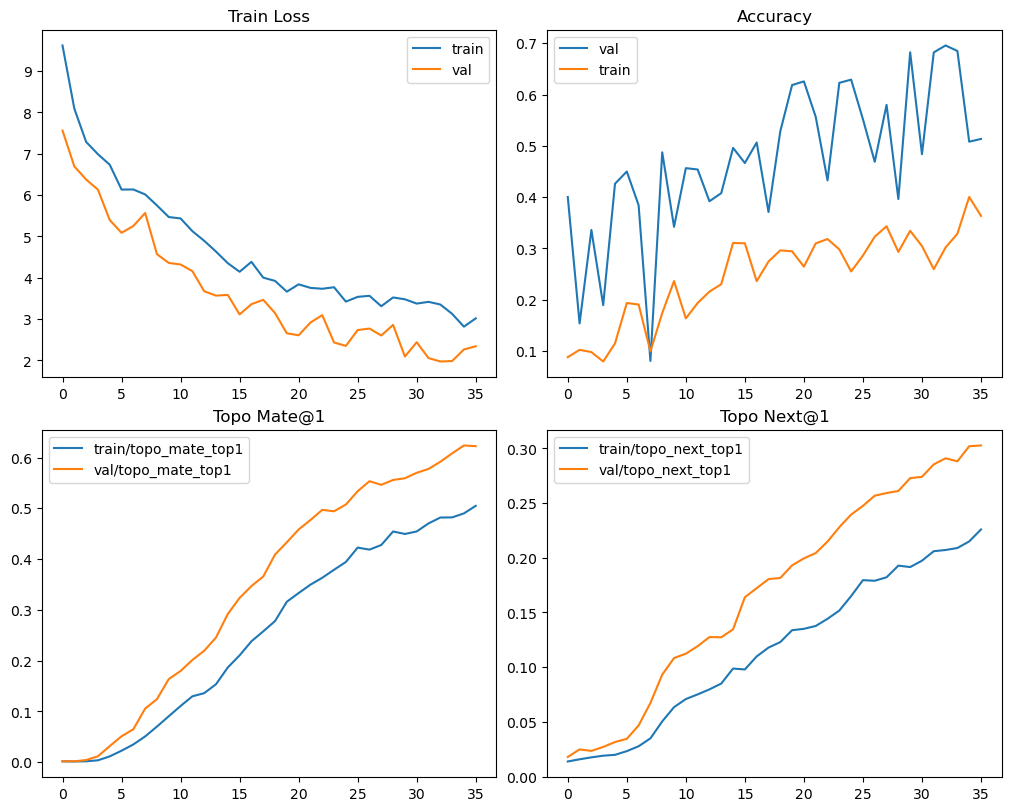

In [114]:
import matplotlib.pyplot as plt

metrics_csv = REPORTS_DIR / "ssl_brep" / "version_29" / "metrics.csv"


train_keys = ["train_infoNCE_acc","train_loss","train_loss_con","train_loss_next","train_loss_mate",
              "train_topo_next_top1","train_topo_mate_top1"]

val_keys   = ["val_infoNCE_acc","val_loss", "val_topo_next_top1","val_topo_mate_top1"]


clean = load_and_clean_csv(str(metrics_csv), train_keys, val_keys)



fig, axs = plt.subplots(2, 2, figsize=(10,8), constrained_layout=True)

axs[0,0].plot(clean["epoch"], clean["train_loss"], label="train")
axs[0,0].plot(clean["epoch"], clean.get("val_loss"), label="val")
axs[0,0].set_title("Train Loss"); axs[0,0].legend()

axs[0,1].plot(clean["epoch"], clean["val_infoNCE_acc"], label="val")
axs[0,1].plot(clean["epoch"], clean["train_infoNCE_acc"], label="train")
axs[0,1].set_title("Accuracy"); axs[0,1].legend()

axs[1,0].plot(clean["epoch"], clean["train_topo_mate_top1"], label="train/topo_mate_top1")
axs[1,0].plot(clean["epoch"], clean["val_topo_mate_top1"], label="val/topo_mate_top1")
axs[1,0].set_title("Topo Mate@1"); axs[1,0].legend()

axs[1,1].plot(clean["epoch"], clean["train_topo_next_top1"], label="train/topo_next_top1")
axs[1,1].plot(clean["epoch"], clean["val_topo_next_top1"], label="val/topo_next_top1")
axs[1,1].set_title("Topo Next@1"); axs[1,1].legend()

plt.show()


In [58]:
from __future__ import annotations
from typing import Dict, List, Tuple
from pathlib import Path
import numpy as np
import torch
from torch import Tensor
from torch_geometric.nn import global_mean_pool, global_max_pool

# _embed(batch) должен возвращать {'coedge': [NC,Dc], 'face': [NF,Df], 'edge': ...}

def pool_model_embedding(
    z_coedge: Tensor, z_face: Tensor,
    co_batch: Tensor, fa_batch: Tensor
) -> Tensor:
    zc_mean = global_mean_pool(z_coedge, co_batch)  # [B,Dc]
    zc_max  = global_max_pool(z_coedge, co_batch)   # [B,Dc]
    zf_mean = global_mean_pool(z_face,   fa_batch)  # [B,Df]
    z = torch.cat([zc_mean, zc_max, zf_mean], dim=1)  # [B,2*Dc+Df]
    z = torch.nn.functional.normalize(z, dim=-1)
    return z  # [B, D]

@torch.no_grad()
def extract_embeddings(
    model_ckpt: Path,
    data_dir: Path,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
) -> Tuple[List[str], np.ndarray]:

    model = SSLBRepModule.load_from_checkpoint(model_ckpt).to(device).eval()
    ds = BRepNPZDataset(data_dir)
    ids: List[str] = []
    embs: List[np.ndarray] = []
    for i in range(len(ds)):
        data = ds.get(i)
        # Для одного графа нет batch-векторов: создаём нулевые
        data = data.to(device)
        z = model._embed(data)  # {'coedge': [NC,Dc], 'face': [NF,Df], ...}
        co_batch = torch.zeros(z["coedge"].size(0), dtype=torch.long, device=device)
        fa_batch = torch.zeros(z["face"].size(0),   dtype=torch.long, device=device)
        g = pool_model_embedding(z["coedge"], z["face"], co_batch, fa_batch)  # [1,D]
        embs.append(g.squeeze(0).cpu().numpy())
        ids.append(ds.files[i].stem)  # имена файлов как идентификаторы
    E = np.stack(embs).astype("float32")  # [N,D]
    # К косинусу: L2-нормировка (на всякий случай ещё раз)
    E /= np.linalg.norm(E, axis=1, keepdims=True) + 1e-8
    return ids, E

def topk_similar(E: np.ndarray, k: int = 10, include_self: bool = True) -> np.ndarray:
    S = E @ E.T  # косинус при L2-нормировке
    if not include_self:
        np.fill_diagonal(S, -1.0)  # исключаем self только при анализе соседей
    topk_idx = np.argpartition(-S, kth=range(k), axis=1)[:, :k] # type: ignore
    row_sort = np.argsort(-S[np.arange(S.shape[0])[:, None], topk_idx], axis=1) # type: ignore
    return topk_idx[np.arange(S.shape[0])[:, None], row_sort]


In [115]:
ckpt = MODELS_DIR / "ssl-brep-epoch=32-val_infoNCE_acc=0.696.ckpt"
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "42. Ejector"
data_dir = Path(BREPNET_NPZ_DIR)
ids, E = extract_embeddings(ckpt, data_dir)

topk_idx = topk_similar(E, k=10)
for i, nn_idx in enumerate(topk_idx[:15]):
    print("Query:", ids[i])
    print("Top-10:", [ids[j] for j in nn_idx])
    print("---")

Query: 42. Ejector-01.prt
Top-10: ['42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector.prt', '42. Ejector-02', '42. Ejector-06.prt', '42. Ejector-07.prt', '42. Ejector-08.prt', 'Зацеп трубки направляющий 7.prt', 'Зацеп трубки направляющий 8.prt', '42. Ejector-09.prt']
---
Query: 42. Ejector-02
Top-10: ['42. Ejector-02', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector.prt', '42. Ejector-06.prt', '42. Ejector-07.prt', '42. Ejector-08.prt', 'Зацеп трубки направляющий 7.prt', 'Зацеп трубки направляющий 8.prt', '42. Ejector-09.prt']
---
Query: 42. Ejector-03.prt
Top-10: ['42. Ejector-03.prt', '42. Ejector-04.prt', '42. Ejector-09.prt', '44. Extractor Pin-09.prt', '42. Ejector-10.prt', 'Зацеп трубки направляющий 7.prt', '44. Extractor Pin-10.prt', '42. Ejector-02', '44. Extractor Pin-08.prt', 'Защелка 10.prt']
---
Query: 42. Ejector-04.prt
Top-10: ['42. Ejector-04.prt', '42. Ejector-03.prt', '42. Ejector-09.prt', '42. Ejector-10.prt', 'Зацеп трубки направляющий 7.prt', '44. Ext

In [ ]:
# retrieval/search_by_name.py
from __future__ import annotations
from typing import List, Tuple, Optional
import numpy as np


def find_query_indices(ids: List[str], query: str, case_insensitive: bool = True) -> List[int]:
    """
    Возвращает список индексов моделей, чьи имена содержат query (подстрока).
    """
    q = query.lower() if case_insensitive else query
    hits = []
    for i, name in enumerate(ids):
        s = name.lower() if case_insensitive else name
        if q in s:
            hits.append(i)
    return hits


def cosine_similarity_matrix(E: np.ndarray) -> np.ndarray:
    """
    Предполагается, что E уже L2-нормирован по строкам. Возвращает S=E@E^T.
    """
    return E @ E.T


def rank_all_by_query(
    ids: List[str],
    E: np.ndarray,
    query_idx: int,
    include_self: bool = True,
) -> List[Tuple[int, float, str]]:
    """
    Ранжирует все объекты датасета по косинусной схожести с указанным query_idx.
    Возвращает список (rank, similarity, name) для всего набора.
    """
    assert 0 <= query_idx < len(ids)
    s = (E[query_idx:query_idx+1] @ E.T).ravel()            # [N]
    if not include_self:
        s[query_idx] = -1.0
    order = np.argsort(-s)                                  # type: ignore
    out: List[Tuple[int, float, str]] = []
    for rank, j in enumerate(order, start=1):
        sim = float(s[j])
        out.append((rank, sim, ids[j]))
    return out


def search_by_name(
    ids: List[str],
    E: np.ndarray,
    query_name: str,
    include_self: bool = True,
    max_print: Optional[int] = 50,
) -> List[Tuple[int, float, str]]:
    """
    Находит по имени/подстроке все совпадения и печатает ранжированный список по косинусу для каждого совпадения.
    Возвращает последний сформированный список (если матчей несколько).
    """
    hits = find_query_indices(ids, query_name)
    if len(hits) == 0:
        print(f"Запрос '{query_name}': совпадений не найдено")
        return []
    last_result: List[Tuple[int, float, str]] = []
    for idx in hits:
        print(f"\nЗапрос: {ids[idx]}")
        ranked = rank_all_by_query(ids, E, idx, include_self=include_self)
        last_result = ranked
        # формат: номер, %, имя
        for rank, sim, name in (ranked if max_print is None else ranked[:max_print]):
            pct = round(100.0 * sim, 2)
            print(f"{rank:4d}. {pct:6.2f}%  {name}")
    return last_result

In [116]:
ckpt = MODELS_DIR / "ssl-brep-epoch=32-val_infoNCE_acc=0.696.ckpt"
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "Затвор"

ids, E = extract_embeddings(model_ckpt=ckpt, data_dir=BREPNET_NPZ_DIR)


results = search_by_name(ids, E, query_name="Затвор 1.prt", include_self=True, max_print=30)

# for rank, sim, name in results:
#     print(f"{rank:4d}. {sim:6.2f}  {name}")


# _ = search_by_name(ids, E, query_name="42. Ejector_body_1.stp", include_self=False, max_print=20)


Запрос: Затвор 1.prt
   1. 100.00%  Затвор 1.prt
   2.  99.94%  Затвор 2.prt
   3.  99.78%  Затвор 3.prt
   4.  99.73%  Затвор.prt
   5.  98.63%  Колодка прицельная 2.prt
   6.  98.43%  Защелка 2.prt
   7.  98.42%  Защелка 3.prt
   8.  98.35%  Затвор 5.prt
   9.  98.35%  Затвор 6.prt
  10.  98.35%  Затвор 9.prt
  11.  98.35%  Затвор 7.prt
  12.  98.34%  Затвор 8.prt
  13.  98.33%  Кожух 6.prt
  14.  98.33%  Защелка АК 6.prt
  15.  98.33%  Кожух 8.prt
  16.  98.32%  Защелка АК 8.prt
  17.  98.32%  Защелка АК 7.prt
  18.  98.32%  Кожух 7.prt
  19.  98.31%  Защелка АК 4.prt
  20.  98.31%  Защелка 6.prt
  21.  98.30%  Защелка 9.prt
  22.  98.29%  Защелка 8.prt
  23.  98.27%  Защелка 7.prt
  24.  98.27%  Защелка АК 5.prt
  25.  98.27%  Камера газовая 1.prt
  26.  98.26%  Затвор 4.prt
  27.  98.25%  Защелка АК 3.prt
  28.  98.22%  Камера газовая.prt
  29.  98.21%  Колодка приклада 9.prt
  30.  98.20%  Колодка приклада 8.prt


In [ ]:
query_id = 37

dataset_item = dataset[query_id]
print(f"Dataset item keys: {list(dataset_item.keys())}")
print(f'Model ID: {dataset_item["model_id"]}')
print(f'STEP file path: {dataset_item["step_path"]}')

print(f"BRepNet features shape: {dataset_item['brepnet_features'].shape}")
print(f"DINO features shape: {dataset_item['dino_features'].shape}")
print(f"Face features shape: {dataset_item['face_features']}")

Dataset item keys: ['model_id', 'step_path', 'brepnet_features', 'dino_features', 'face_features', 'face_point_grids', 'edge_features', 'coedge_features', 'coedge_point_grids', 'coedge_lcs', 'coedge_scale_factors', 'coedge_reverse_flags', 'coedge_to_next', 'coedge_to_mate', 'coedge_to_face', 'coedge_to_edge']
Model ID: 44. Extractor Pin-04
STEP file path: D:\workspace\projects\freelance\Fusion3DNet\data\processed\dataset_129\stp\44. Extractor Pin-04.prt.stp
BRepNet features shape: (7, 17)
DINO features shape: (8, 384)
Face features shape: [[-0.81062318  1.21544925 -0.24000889 -0.07543912 -0.24188691  4.78253405
  -0.11125885]
 [ 1.23349414 -0.82265791 -0.24000889 -0.07543912 -0.24188691  0.01020785
  -0.11125885]
 [ 1.23349414 -0.82265791 -0.24000889 -0.07543912 -0.24188691 -0.03362011
  -0.11125885]
 [-0.81062318 -0.82265791  4.16609125 -0.07543912 -0.24188691 -0.18844317
  -0.11125885]
 [-0.81062318 -0.82265791  4.16609125 -0.07543912 -0.24188691 -0.16069746
  -0.11125885]
 [-0.81062

In [ ]:
import numpy as np

def get_main_shape(face_features):
    is_plane = face_features[:, 0]
    is_cylinder = face_features[:, 1]
    is_cone = face_features[:, 2]
    is_sphere = face_features[:, 3]
    is_torus = face_features[:, 4]
    areas = face_features[:, 5]

    total_area = areas.sum()
    plane_area = areas[is_plane > 0.0].sum()
    cylinder_area = areas[is_cylinder > 0.0].sum()
    cone_area = areas[is_cone > 0.0].sum()  
    sphere_area = areas[is_sphere > 0.0].sum()
    torus_area = areas[is_torus > 0.0].sum()

    # Основная форма — по максимальной доле площади
    shape_areas = {
        "prismatic": plane_area, # плоские и призматические
        "cylindrical": cylinder_area, # цилиндрические
        "conical": cone_area, # конические
        "spherical": sphere_area, # сферические
        "toroidal": torus_area # тороидальные
    }
    main_shape = max(shape_areas, key=lambda k: shape_areas[k])
    if shape_areas[main_shape] / total_area < 0.5:
        return "mixed"
    return main_shape

# Для всего датасета
shape_labels = [get_main_shape(item['brepnet_features']) for item in dataset]

# Пример: вывести все цилиндрические детали
for idx, label in enumerate(shape_labels):
    if label == "prismatic":
        print(f"{idx}: {dataset[idx]['model_id']} | {label}")



21: 42. Silencer Fix-10 | prismatic
32: 43. Extractor-10 | prismatic
63: Зацеп трубки направляющий 8 | prismatic
65: Защелка | prismatic
66: Защелка 1 | prismatic
67: Защелка 10 | prismatic
68: Защелка 2 | prismatic
69: Защелка 3 | prismatic
70: Защелка 4 | prismatic
71: Защелка 5 | prismatic
72: Защелка 6 | prismatic
73: Защелка 7 | prismatic
74: Защелка 8 | prismatic
75: Защелка 9 | prismatic
